In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timezone
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from google.cloud import bigquery
client = bigquery.Client()

In [4]:
traffic_data = pd.read_csv('DataSets/TrafficData.csv')
traffic_data.head()

,day,maximum_fare,minimum_fare,avg_fare,std_dev_fare,rides
0,2013-01-01,910025.0,0.0,1377.74,13320.48,56953
1,2013-01-02,900054.0,0.0,1237.99,8560.35,36830
2,2013-01-03,800130.0,0.0,1233.54,10208.86,38808
3,2013-01-04,600046.0,0.0,1043.77,3515.89,50391
4,2013-01-05,300112.0,0.0,1006.10,1779.21,48354


In [27]:
def get_taxi_and_temperature_data(from_year,to_year):
    taxi_sql=f"""
        SELECT
          EXTRACT(date FROM trip_start_timestamp) AS day,
          EXTRACT(year FROM trip_start_timestamp) AS year,
          FORMAT('%3.2f', MAX(fare)) AS maximum_fare,
          FORMAT('%3.2f', MIN(fare)) AS minimum_fare,
          FORMAT('%3.2f', AVG(fare)) AS avg_fare,
          FORMAT('%3.2f', STDDEV(fare)) AS std_dev_fare,
          COUNT(1) AS rides
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        GROUP BY
          day,year
        HAVING year BETWEEN {from_year} AND {to_year}
        ORDER BY day"""
    taxi_df = client.query(taxi_sql).to_dataframe()
    taxi_df['day']=pd.to_datetime(taxi_df['day'])
    taxi_df['day']=pd.DatetimeIndex(pd.to_datetime(taxi_df['day'],unit='ms')).tz_localize('UTC')
    
    weather_sql=f"""SELECT
            TIMESTAMP_TRUNC(TIMESTAMP(CONCAT(year, '-', mo, '-', da)),
              DAY) AS date,
            year,
            AVG(temp) AS temperature
          FROM
            `bigquery-public-data.noaa_gsod.gsod*` AS w
          JOIN
            `bigquery-public-data.noaa_gsod.stations` AS s
          ON
            w.stn = s.usaf
            AND s.name = "CHICAGO O'HARE INTERNATIONAL"
          WHERE
            w._TABLE_SUFFIX BETWEEN '{from_year}'
            AND '{to_year}'
          GROUP BY
            date,
            year"""

    weather_df = client.query(weather_sql).to_dataframe()
    weather_df.head()
    merged_df = pd.merge(taxi_df, weather_df, left_on='day', right_on='date')
    return merged_df

In [30]:
merged_data=get_taxi_and_temperature_data('2016','2016')


In [31]:
merged_data

,day,year_x,maximum_fare,minimum_fare,avg_fare,std_dev_fare,rides,date,year_y,temperature
0,2016-01-01 00:00:00+00:00,2016,800054.00,0.00,1158.24,5269.88,65468,2016-01-01 00:00:00+00:00,2016,23.4
1,2016-01-02 00:00:00+00:00,2016,900229.00,0.00,1391.55,10445.71,46554,2016-01-02 00:00:00+00:00,2016,27.0
2,2016-01-03 00:00:00+00:00,2016,800050.00,0.00,1650.03,9268.56,39405,2016-01-03 00:00:00+00:00,2016,26.8
3,2016-01-04 00:00:00+00:00,2016,900090.00,0.00,1454.80,6638.66,46134,2016-01-04 00:00:00+00:00,2016,26.9
4,2016-01-05 00:00:00+00:00,2016,650022.00,0.00,1317.51,3287.98,49066,2016-01-05 00:00:00+00:00,2016,25.5
5,2016-01-06 00:00:00+00:00,2016,99999.00,0.00,1283.59,1542.17,51924,2016-01-06 00:00:00+00:00,2016,28.3
6,2016-01-07 00:00:00+00:00,2016,99999.00,0.00,1315.89,1446.41,54296,2016-01-07 00:00:00+00:00,2016,36.0
7,2016-01-08 00:00:00+00:00,2016,300122.00,0.00,1242.68,1824.04,63715,2016-01-08 00:00:00+00:00,2016,38.5
8,2016-01-09 00:00:00+00:00,2016,96654.00,0.00,1132.73,1125.82,50970,2016-01-09 00:00:00+00:00,2016,37.1
9,2016-01-10 00:00:00+00:00,2016,89550.00,0.00,1366.26,1398.22,43192,2016-01-10 00:00:00+00:00,2016,19.0


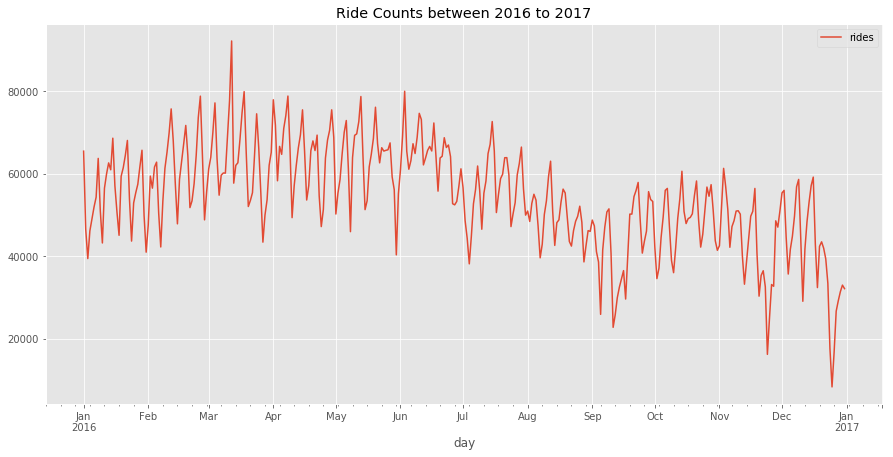

In [33]:
merged_data.plot(x='day',y='rides',figsize=(15,7),title="Ride Counts between 2016 to 2017")

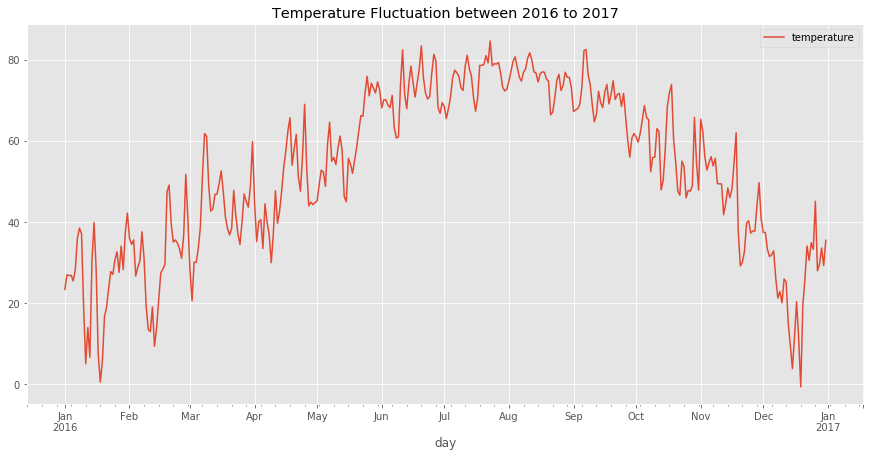

In [35]:
merged_data.plot(x='day',y='temperature',figsize=(15,7),title="Temperature Fluctuation between 2016 to 2017")

Text(0.5,0,'Temperature')

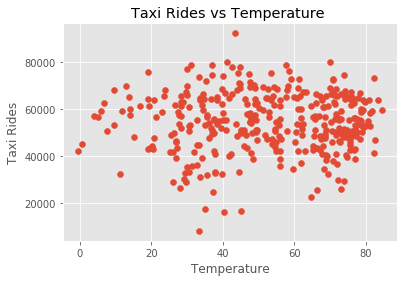

In [36]:
plt.scatter(x=merged_data['temperature'],y=merged_data['rides'])
plt.title('Taxi Rides vs Temperature ')
plt.ylabel("Taxi Rides")
plt.xlabel("Temperature")